In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

pd.options.mode.chained_assignment = None

# Scraper and Correlation Analyzer

In [2]:
#Defining functions.
from datetime import datetime
from dateutil.relativedelta import relativedelta
import calendar
import requests
import io
import json

#Limiting data to that of the last 6 months.
now = datetime.today()
six_months = datetime.today() + relativedelta(months=-6, days = -3)

#Extracts data from coinmetrics.
def coinmetrics(csv_name, start=now, end=now):
    url = 'https://coinmetrics.io/data/' + csv_name + '.csv'
    text = requests.get(url).text
    
    time = (end - start).days
    coin = pd.read_csv(io.StringIO(text))[-time:]
    coin = coin[['date', 'txCount', 'marketcap(USD)', 'price(USD)', 'exchangeVolume(USD)']]
    coin.columns = ['Date', 'Transactions', 'Market Cap', 'Price', 'Exchange Volume']
    coin['Price Change'] = coin['Price'].pct_change()*100
    coin.reset_index(inplace=True, drop=True)
    return coin

#Extracts subreddit data.
def reddit(subreddit, start, end):
    time = (end - start).days
    time_str = str(time + 1)
    api, freq = 'https://api.pushshift.io/reddit/', '&aggs=created_utc&frequency=d&size=0'
    
    sub = requests.get(api +'submission/search/?after='+ time_str +'d&subreddit='+ subreddit + freq)
    com = requests.get(api +'comment/search/?after='+ time_str +'d&subreddit='+ subreddit + freq)
    sub_json, com_json = sub.json(), com.json()
    
    submissions = pd.DataFrame(sub_json['aggs']['created_utc'])
    submissions.columns = ['Submissions', 'UTC']
    comments = pd.DataFrame(com_json['aggs']['created_utc'])
    comments.columns = ['Comments', 'UTC']

    reddit = submissions.merge(comments, on='UTC')
    def convert(date):
        return datetime.utcfromtimestamp(date).strftime('%Y-%m-%d')
    reddit['Date'] = reddit['UTC'].apply(convert)
    return reddit

#Merges subreddit and coin data.
def merged_coin(subtitle, subreddit, start, end):
    coin = coinmetrics(subtitle, start, end)
    sub = reddit(subreddit, start, end)
    coin = coin.merge(sub, on='Date')
    
    coin.drop('UTC', axis=1, inplace=True)
    coin.dropna(inplace=True)
    coin.reset_index(inplace=True, drop=True)
    return coin

#Provided subtitle of csv of coin at coinmetrics, subreddit name, start and end dates, and correlation type.
def correlation(subtitle, subreddit, start=six_months, end=now, corr_type='pearson'):
    coin = merged_coin(subtitle, subreddit, start, end)
    def get_month(date):
        return datetime.strptime(date, '%Y-%m-%d').strftime('%B')
    coin['Month'] = coin['Date'].apply(get_month)
    
    sns.pairplot(coin, hue='Month', palette='viridis', diag_kind='hist')
    plt.suptitle(subtitle + ' Data', fontsize = 24)
    plt.subplots_adjust(top=0.95)
    plt.show()
        
    return coin.corr(method=corr_type)

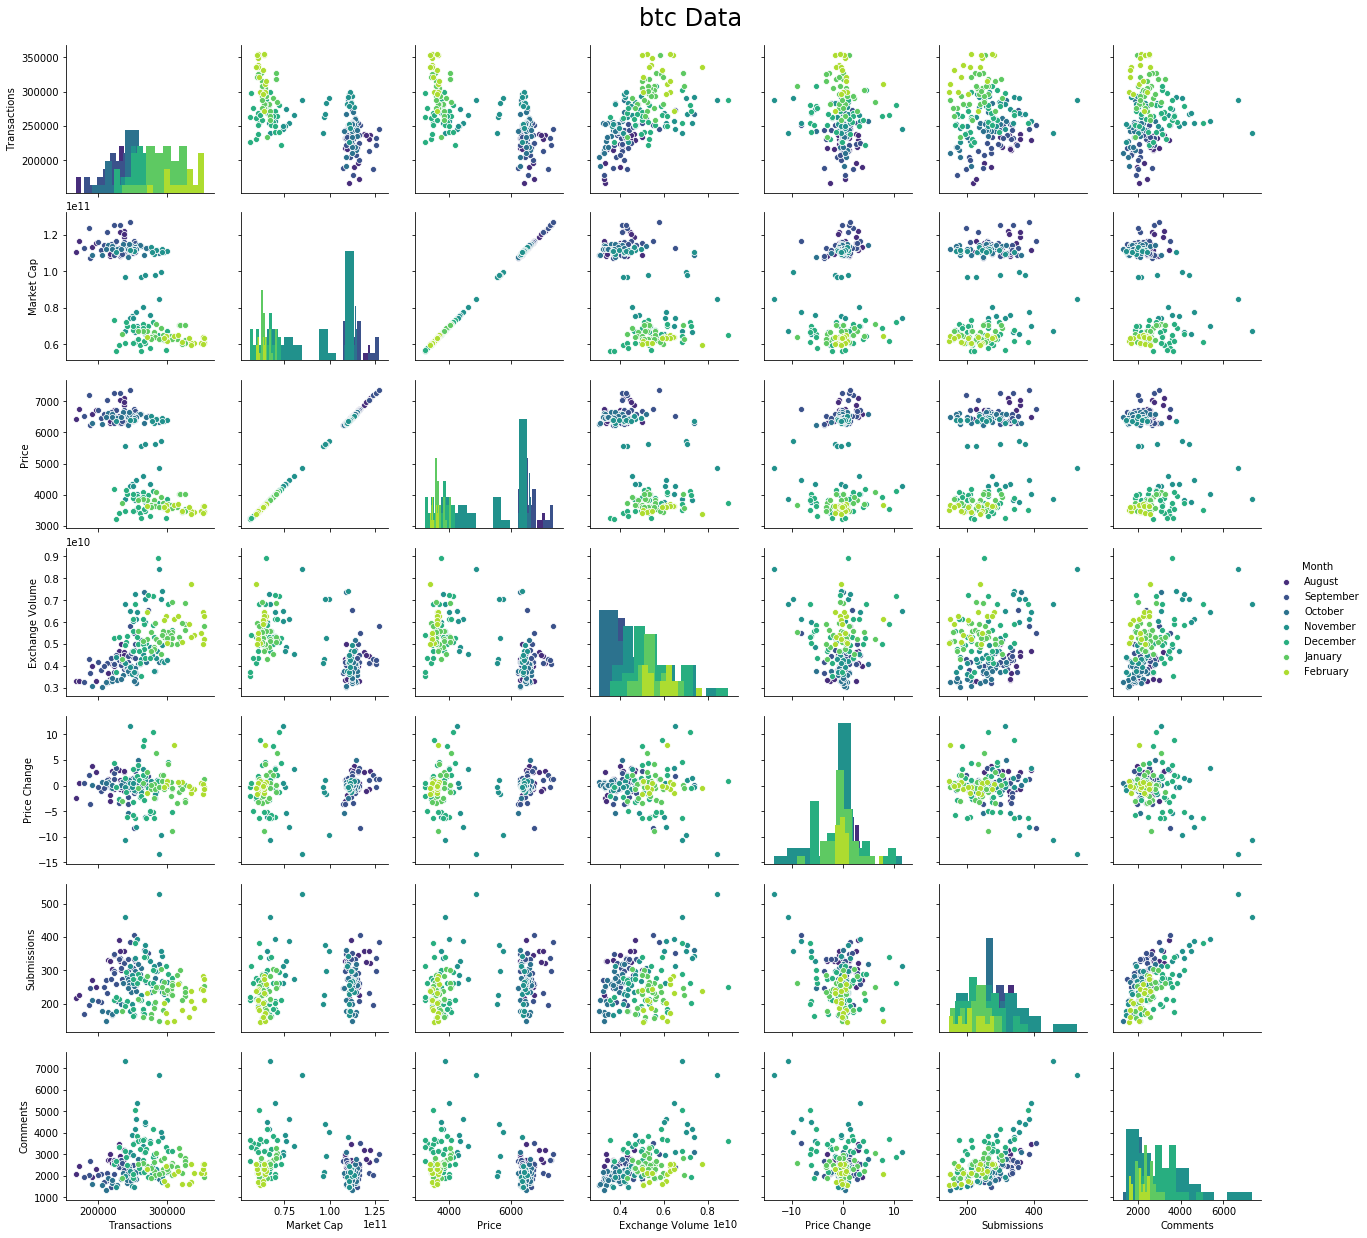

,Transactions,Market Cap,Price,Exchange Volume,Price Change,Submissions,Comments
Transactions,1.000000,-0.633431,-0.637951,0.577170,-0.059854,-0.073068,0.058921
Market Cap,-0.633431,1.000000,0.999953,-0.595100,0.071009,0.244938,-0.293867
Price,-0.637951,0.999953,1.000000,-0.595967,0.070726,0.248156,-0.290649
Exchange Volume,0.577170,-0.595100,-0.595967,1.000000,-0.067198,0.213687,0.504917
Price Change,-0.059854,0.071009,0.070726,-0.067198,1.000000,-0.220995,-0.297349
Submissions,-0.073068,0.244938,0.248156,0.213687,-0.220995,1.000000,0.647668
Comments,0.058921,-0.293867,-0.290649,0.504917,-0.297349,0.647668,1.000000


In [3]:
correlation('btc', 'bitcoin')

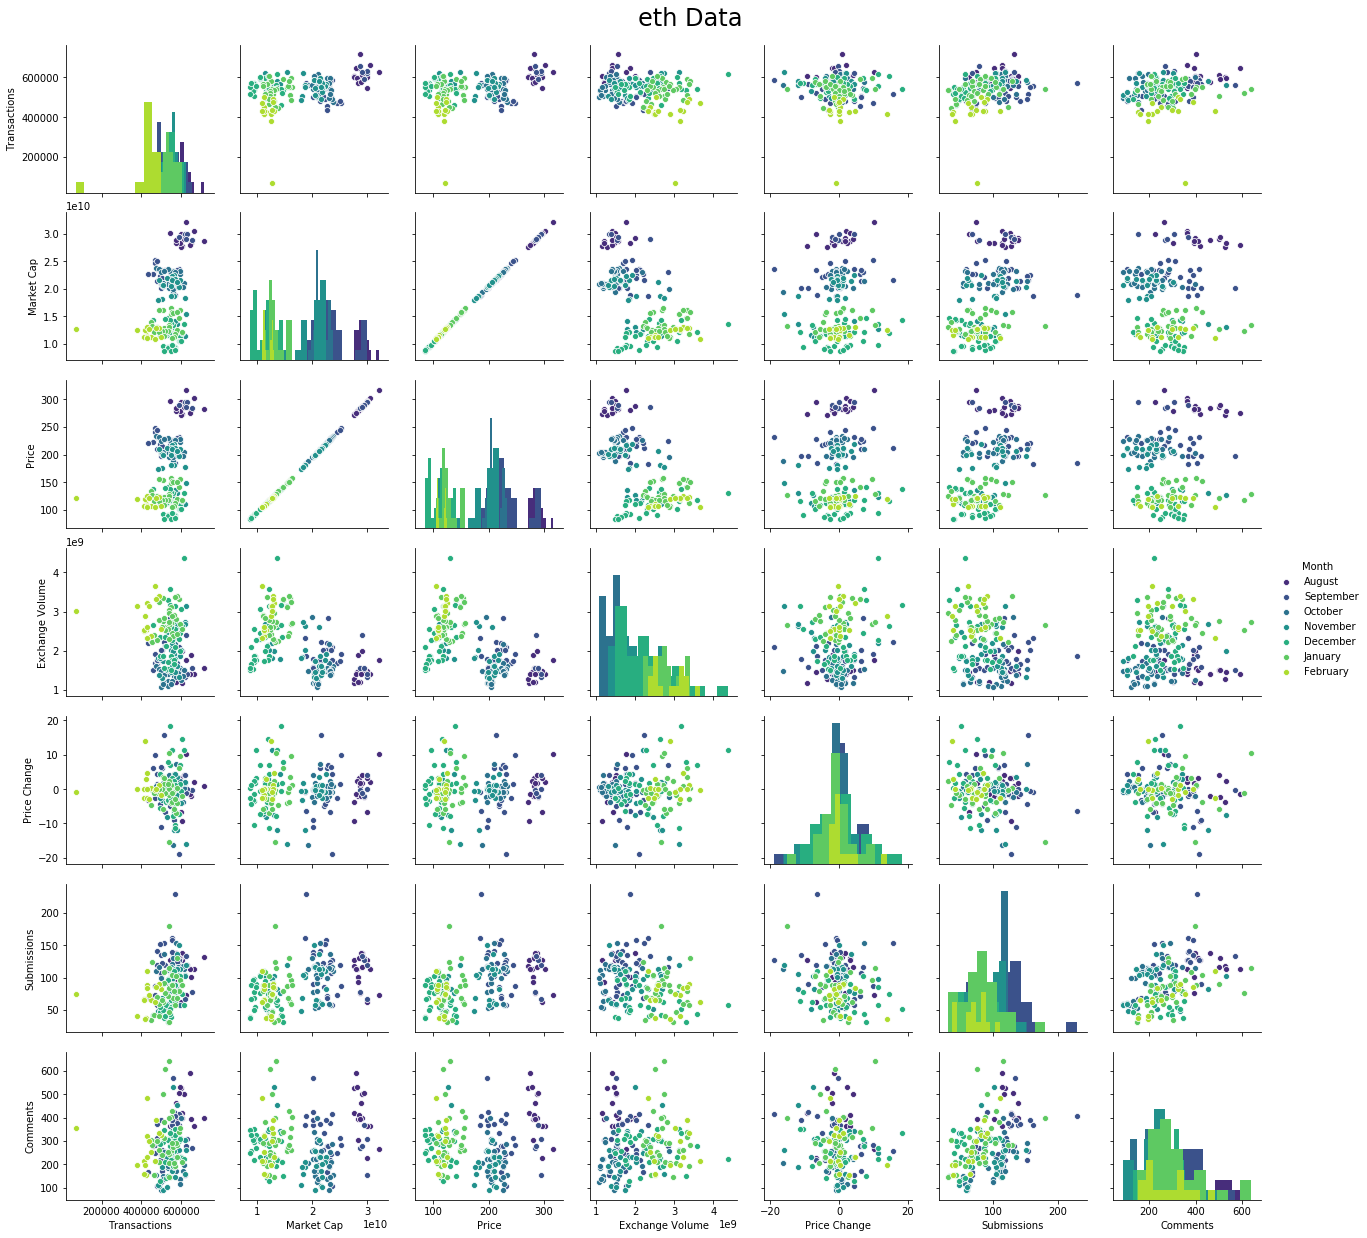

,Transactions,Market Cap,Price,Exchange Volume,Price Change,Submissions,Comments
Transactions,1.000000,0.327522,0.331266,-0.221995,-0.054457,0.330255,0.179842
Market Cap,0.327522,1.000000,0.999899,-0.588852,0.049902,0.449245,0.068892
Price,0.331266,0.999899,1.000000,-0.592365,0.047881,0.451305,0.073867
Exchange Volume,-0.221995,-0.588852,-0.592365,1.000000,0.082000,-0.300487,0.034571
Price Change,-0.054457,0.049902,0.047881,0.082000,1.000000,-0.166448,-0.121482
Submissions,0.330255,0.449245,0.451305,-0.300487,-0.166448,1.000000,0.390969
Comments,0.179842,0.068892,0.073867,0.034571,-0.121482,0.390969,1.000000


In [4]:
correlation('eth', 'ethereum')